In [1]:
using CairoMakie
using GeoMakie
using NCDatasets
using Statistics
using TypedTables
using HypothesisTests

In [117]:
tag = "mystery"
#
#fig2name = tag*"_rh_nino_comp_NH_test.png"
ninoyears = [18 54 90 150 174 234 306 402]
ninayears = [102 114 210 246 318 366 378 390]
# SH
#fig2name = tag*"_rh_nino_comp_SH_test.png"
#ninoyears = [23 35 59 96 155 239 311 347]
#ninayears = [107 119 215 251 263 335 371 383]
function create_indices(years)
  ensoInd = Matrix{Int64}(undef, 8, 6)
  for i in 1:8
    si = years[i]
    ensoInd[i,:] = si:si+5
  end
  #o1=years[1]:years[1]+5
  #ensoInd = [o1 o2 o3 o4 o5 o6 o7 o8]
  return ensoInd
end 

ninoInd = create_indices(ninoyears)
ninaInd = create_indices(ninayears)
#

path="/Users/C823281551/data/ERA5/"

filein  = path*"era5_rh_1990th2023_360x80.nc"
fileclimo = path*"era5_rh_1990th2023_360x80_climo_climatology.nc"

tag = "ERA5"
data   = NCDataset(filein)
data2  = NCDataset(fileclimo)

lat = data["lat"]
lon = data["lon"]
lev = data["pressure_level"]

numfields = 48 
numall    = 408
timeENSO  = collect(1.:1:numfields);
timeall   = collect(1.:1:numall);

lat1      = 1
lat2      = 81
level     = 2 # level 2 should correspond to the 700 hPa pressure level

# should I remove the seasonal cycle before looking at composite ENSO fields?  
rh_var_full  = data["r"]
rh_var_climo = data2["r"]
dims         = size(rh_var_full)

(360, 81, 2, 408)

In [118]:
rh_1            = Array{Union{Missing, Float64}, 4}(undef, dims[1], dims[2], 1, numfields)
rh_2            = Array{Union{Missing, Float64}, 4}(undef, dims[1], dims[2], 1, numfields)
rh_low          = Array{Union{Missing, Float64}, 3}(undef, dims[1], dims[2], numfields)
rh_low_anom     = Array{Union{Missing, Float64}, 3}(undef, dims[1], dims[2], numfields)
rh_high         = Array{Union{Missing, Float64}, 3}(undef, dims[1], dims[2], numfields)
rh_high_anom    = Array{Union{Missing, Float64}, 3}(undef, dims[1], dims[2], numfields)
rh_tot          = Array{Union{Missing, Float64}, 3}(undef, dims[1], dims[2], numall)
rh_tot_anom     = Array{Union{Missing, Float64}, 3}(undef, dims[1], dims[2], numall)

360×81×408 Array{Union{Missing, Float64}, 3}:
[:, :, 1] =
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     mi

In [119]:
endi = 48
# low is an array that contains the timesteps representing the negative phase of ENSO
# high is an array that contains the timesteps representing the positive phase of ENSO
low = ninaInd
high = ninoInd

# select the case determining if rh will be plotted at one level or at the average of two
pcase = 0# pcase = 0 corresponds to plotting rh on 1 level
# calculate total rh field, for all times
level=2 # level 2 should correspond to the 700 hPa pressure level. 
for i in 1:408
    rh_tot[:,lat1:lat2,i]   = rh_var_full[:,lat1:lat2,level,i] 
    #rh_tot_anom[:,lat1:lat2,i]   = rh_var[:,lat1:lat2,i] 
end
for i in 1:endi
    # compute from raw RH data:
    # low values, la nina
    rh_2[:,lat1:lat2,1,i]   = rh_var_full[:,lat1:lat2,level,low[i]]
    rh_low[:,lat1:lat2,i]   = rh_2[:,lat1:lat2,1,i] 
    # high values, el nino
    rh_2[:,lat1:lat2,1,i]   = rh_var_full[:,lat1:lat2,level,high[i]]
    rh_high[:,lat1:lat2,i]  = rh_2[:,lat1:lat2,1,i] 
    # compute from anomolous RH data:
    # low values, la nina
    #rh_low_anom[:,lat1:lat2,i]   = rh_var[:,lat1:lat2,low[i]] 
    # high values, el nino
    #rh_high_anom[:,lat1:lat2,i]  = rh_var[:,lat1:lat2,high[i]] 
end
rh_tot_tmn  = mean(rh_tot, dims=3)
#rh_tot_anom_tmn  = mean(rh_tot_anom, dims=3)
rh_high_tmn = mean(rh_high, dims=3)
rh_low_tmn  = mean(rh_low, dims=3)
#rh_high_anom_tmn = mean(rh_high_anom, dims=3)
#rh_low_anom_tmn  = mean(rh_low_anom, dims=3)
# rh_high_tmn
rh_NinoMmn = rh_high_tmn .- rh_tot_tmn;
rh_NinaMmn = rh_low_tmn .- rh_tot_tmn;
# rh_low_anom_tmn
#rh_ninoMnina_anom = rh_high_anom .- rh_low_anom
#rh_comp_anom_mn   = mean(rh_ninoMnina_anom, dims=3)
rh_ninoMnina = rh_high .- rh_low
rh_comp_mn   = mean(rh_ninoMnina, dims=3)

data_2_plot_tot  = rh_tot_tmn
data_2_plot_comp = rh_high_tmn - rh_low_tmn
#data_2_plot_anom = rh_high_anom_tmn - rh_low_anom_tmn

360×81×1 Array{Float64, 3}:
[:, :, 1] =
  1.93323     1.55884     1.27096     …  -2.24039   -2.18428   -1.45784
  2.14348     2.24113     1.96184        -2.19808   -2.43819   -1.67814
  2.61194     2.66052     2.25529        -2.27693   -2.41744   -1.83858
  3.2061      3.18522     2.56519        -2.41947   -2.3702    -1.84712
  3.57007     3.43124     2.93986        -2.30338   -2.31384   -1.83227
  3.42741     3.47372     3.43356     …  -2.00594   -2.09375   -1.66666
  3.41248     3.74219     3.81079        -1.61889   -1.6853    -1.31705
  3.81108     4.47018     4.48719        -1.69291   -1.3608    -1.02116
  4.12085     5.03105     4.79956        -1.74894   -1.2976    -0.90641
  4.44332     5.13025     4.75334        -1.34806   -1.14091   -1.00854
  4.6757      4.81234     4.4126      …  -0.982419  -0.657387  -0.686277
  4.58423     4.49764     3.95244        -0.883176  -0.342567  -0.297157
  4.65438     4.34253     3.43388        -0.72656   -0.069781  -0.0353572
  ⋮                 

In [120]:
# try different functions to get p-values from the HypothesisTests package
X2 = Float64.(timeENSO);
d1 = 360
d2 = 81
pvalgrid  = Array{Union{Missing, Float64}, 2}(undef, d1, d2)
pvallow   = Array{Union{Missing, Float64}, 2}(undef, d1, d2)
pvalhigh  = Array{Union{Missing, Float64}, 2}(undef, d1, d2)
intVal    = Array{Union{Missing, Float64}, 2}(undef, d1, d2)

for i in 1:360 # dims[1] longitudes
    for j in 1:81 # dims[2] latitudes
        #Yind = rh_ninoMnina_anom[i,j,:];
        Yind = rh_ninoMnina[i,j,:];
        if any(ismissing, Yind)
            #println("missing value found ")
        else
        # need to somehow check if Yind contains missing data, and if so, then don't proceed to the lm step.  
            Ytemp = Float64.(Yind)
            tab   = Table(X = X2, Y = Ytemp);
            ols_temp = OneSampleTTest(Ytemp)
            pvalgrid[i,j] = pvalue(ols_temp)
            #global test = confint(ols_temp)
            rang = confint(ols_temp, level = 0.95, tail = :both);
            pvallow[i,j] = rang[1]
            pvalhigh[i,j] = rang[2]
            # test to make sure that 0 is not contained between the upper/lower 95% range
            intVal[i,j] = sign(pvalhigh[i,j]) + sign(pvallow[i,j])
        end
    end
end

arrN = reshape(pvalgrid, (d1*d2));
sortedP = sort(arrN)

lengthP = d1*d2
pAxis = collect(1:1:lengthP);
wilks0p05 = (0.05/lengthP) .* pAxis
wilks0p1 = (0.1/lengthP) .* pAxis
p0p05 = zeros(lengthP) .+ 0.05;
wilksArray = zeros(lengthP);


In [121]:
for i in 1:20000
    wilksArray[i] = sortedP[i] - wilks0p05[i]
end

#psign = sign.(sortedP)
psign = sign.(wilksArray)
diffs = diff(psign)
psign_ind = findall(!iszero, diffs)
println("change of sign should be intersection point of sortedP and wilks0p05: ",psign_ind)
println("pvalue at intersection of sorted pvalues and Wilks FDR pvalue is: ",sortedP[psign_ind[1]])

# this is the p-value based on the FDR (false detection rate) described in Wilkes, 2016
pFDR = sortedP[psign_ind[1]]

# create a boolean array of points that indicate statistical significance
woman      = falses(d1,d2);
c1 = coalesce.(pvalgrid, false);
c2 = coalesce.(intVal, false);
for i in 1:d1
    for j in 1:d2
        #woman[i,j] = c1[i,j] < 0.05 && c2[i,j] != 0.0
        woman[i,j] = c1[i,j] < pFDR && c2[i,j] != 0.0
        #woman[i,j] = c1[i,j] < pFDR
    end
end
# grab all the points that are labelled as 'true' or 1.  
points = findall(x -> x == 1, woman);
# points is now a CartesianIndex object, which cannot be directly used with scatter.  
# we have to create coordinate arrays from points: 
x_coords = [idx.I[1] for idx in points];
y_coords = [idx.I[2] for idx in points];

# shift index arrays to correspond to trad lat/lon defs
x_lats = x_coords .- 180;
#x_lats = x_coords
#y_lons = y_coords .- 90; # shifting the south point from 0 to -90
y_lons = y_coords .- 40; # shifting the south point from 0 to -40

change of sign should be intersection point of sortedP and wilks0p05: [7628, 20000]
pvalue at intersection of sorted pvalues and Wilks FDR pvalue is: 0.013074868170117236


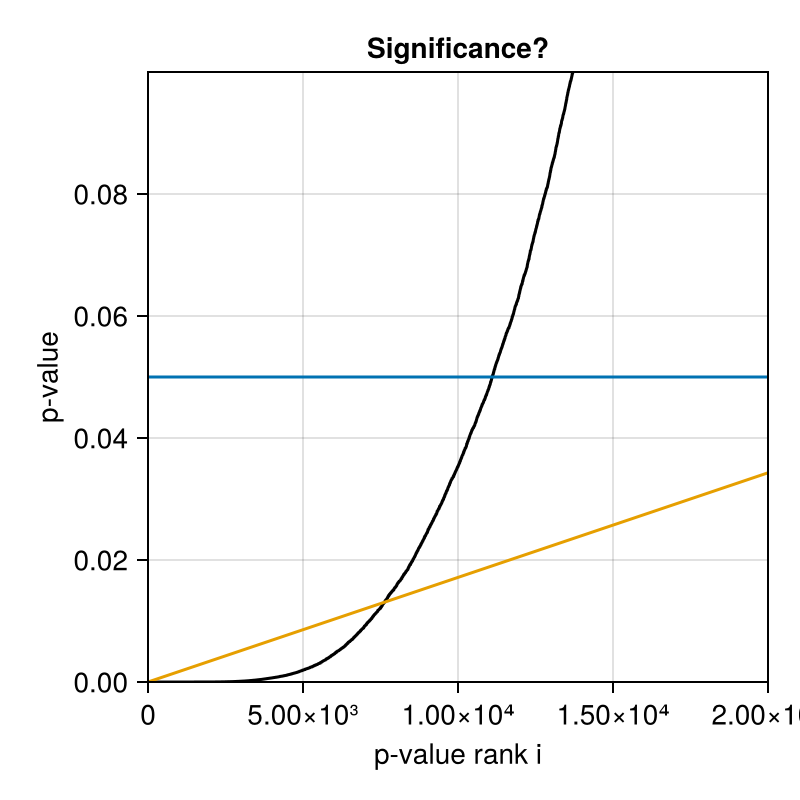

In [122]:
fig3 = Figure(;
    size = (400,400),
    )
ax = Axis(fig3[1,1];
    xlabel = "p-value rank i",
    ylabel = "p-value",
    title  = "Significance?",
    limits=(0,20000,0,0.1),
    )
#lines!(C,ts_roni_sm, linestyle = :solid)
lines!(ax,pAxis[:],sortedP[:], color = :black)
lines!(ax,pAxis[:],p0p05[:])
lines!(ax,pAxis[:],wilks0p05[:])
#save("sig_vws_Wilks.png", fig3, px_per_unit=6.0)
fig3

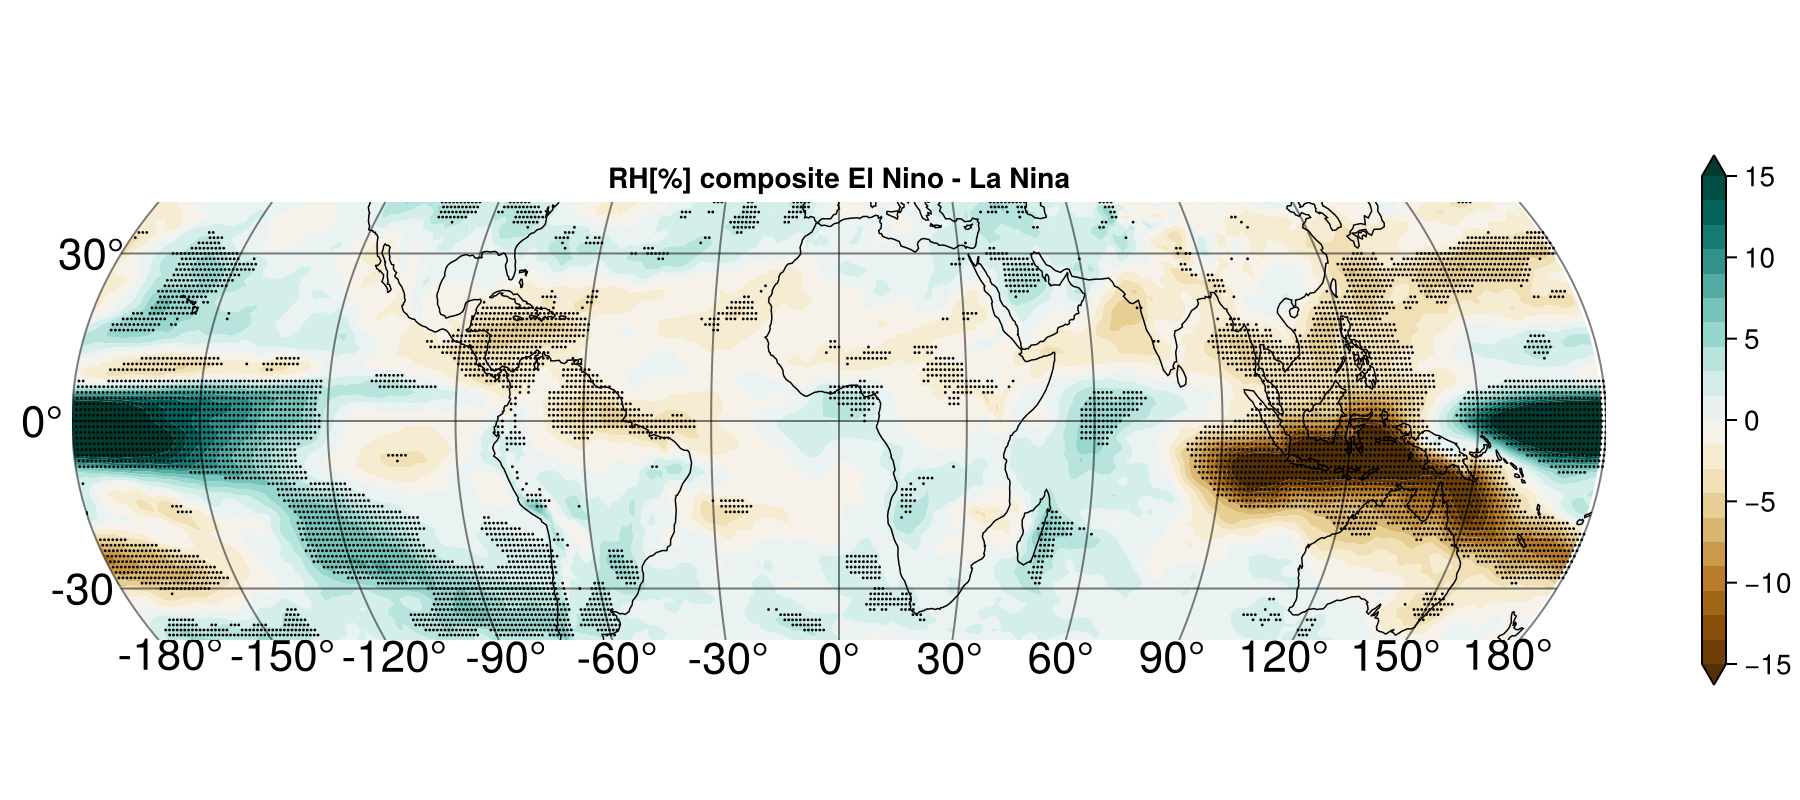

In [123]:
f1 = Figure(;
    figure_padding=(5,5,10,10),
    #figure_padding=(20,20,20,20),
    backgroundcolor=:white,
    size=(900,400),
    )
ax = GeoAxis(f1[1,1];
    xticks = -180:30:180, 
    #xticks = 0:30:360, 
    #yticks = -40:20:40,
    yticks = -90:30:90,
    #yticklabels=("0"),
    ylabel="latitude",
    xlabel="longitude",
    limits=(-180,180,-40,40),
    #xticklabelpad = 10.0,
    #yticklabelpad = 30.0,
    #set_zero_subnormals(false),
    title="RH[%] composite El Nino - La Nina",
    xticklabelsize = 22, # 14,16 are pretty reasonable sizes
    yticklabelsize = 22, # 22 used for 8 panel figure that needs larger font
    )
    bb = contourf!(ax, lon, lat, data_2_plot_comp[:,:,1], 
         #levels = range(0, 50, length = 25), # tos
         levels = range(-15, 15, length = 21), # rh
         #colormap = :Blues_8,
         #colormap = :broc,
         #colormap = :bam,
         colormap = :BrBg,
         #colormap = :batlow,
         #colormap = :vik,
         extendlow = :auto, extendhigh = :auto
    )
    lines!(ax, GeoMakie.coastlines(), color = :black, linewidth=0.75)
    Colorbar(f1[1,2], bb)
#scatter!(ax, x_lats, y_lons, marker = :utriangle, markersize=3, color = :black)
scatter!(ax, x_lats, y_lons, marker = :circle, markersize=2, color = :black)
f1
#save("rh_fig.png", f4, px_per_unit=6.0)

In [124]:
save("rh_NH_p05_Wilks.png", f1, px_per_unit=6.0)

In [113]:
180*360

64800